# Cloud-radiative heating for hurrican Bill in August 2009

CRH as derived from CloudSat/Calipso 2BFLXHR-LIDAR.

Data was obtained from https://www.cloudsat.cira.colostate.edu/:

- 2B-FLXHR-LIDAR: heating rates and cloud mask 
- MODIS-AUX: satellite track in geographical coordinates

Both datasets are from product release 5. The granule is 17611.

For conversion from hdf
to netcdf, ncks was used.

https://csmerge.cira.colostate.edu/quicklook_images_remote/1A-AUX/1A-AUX.R05/2009/231/2009231162830_17611_CS_1A-AUX_GRANULE_P_R05_E00_1AA.htm

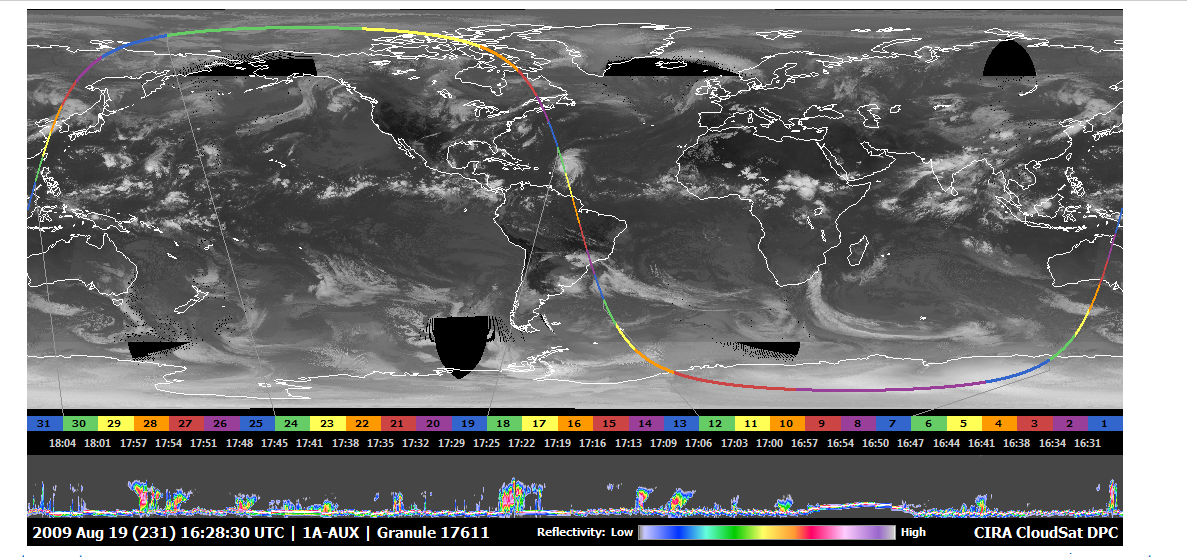

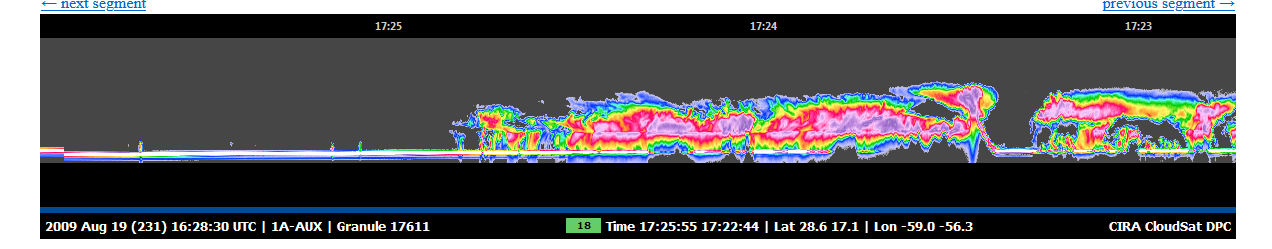

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt

### Load data and compute heating rates

In [2]:
path="/scratch/b/b380459/cccm/"

ds = xr.open_dataset(path+"2009231162830_17611_CS_2B-FLXHR-LIDAR_GRANULE_P2_R05_E02_F00.ncks.nc")

# rename dimensions to shorter names
ds = ds.rename({"nz_flux_flxhr2b:2B-FLXHR-LIDAR": "nz_flux", "nbands_flxhr2b:2B-FLXHR-LIDAR": "nbands", "nray:2B-FLXHR-LIDAR": "nray",
                "nz_hr_flxhr2b:2B-FLXHR-LIDAR": "nz_hr"})

# cloudsat track data, use modis as a good approximation
ds_track = xr.open_dataset(path+"2009231162830_17611_CS_MODIS-AUX_GRANULE_P_R05_E02_F00.ncks.nc")
lat = ds_track["MODIS_latitude"][:,0]

In [3]:
height = ds["Height"].mean("nray")
nray = ds["nray"].values

In [4]:
# compute conversion factor from known heating rate QR to flux divergence
# we here compute it based on SW QR and fluxes, it should equally work for LW CR and fluxes
conv = ds["QR"][0].values/(ds["FD"].diff("nz_flux")[0]-ds["FU"].diff("nz_flux")[0]).values

# compute all-sky, clear-sky and cloud-radiative heating rates from fluxes
sw_as = 0.01*(conv*(ds["FD"].diff("nz_flux")[0]-ds["FU"].diff("nz_flux")[0]))
lw_as = 0.01*(conv*(ds["FD"].diff("nz_flux")[1]-ds["FU"].diff("nz_flux")[1]))
sw_cs = 0.01*(conv*(ds["FD_NC"].diff("nz_flux")[0]-ds["FU_NC"].diff("nz_flux")[0]))
lw_cs = 0.01*(conv*(ds["FD_NC"].diff("nz_flux")[1]-ds["FU_NC"].diff("nz_flux")[1]))
sw_crh = sw_as - sw_cs
lw_crh = lw_as - lw_cs

/tmp/ipykernel_3148612/2095976432.py:3: RuntimeWarning: divide by zero encountered in divide
  conv = ds["QR"][0].values/(ds["FD"].diff("nz_flux")[0]-ds["FU"].diff("nz_flux")[0]).values
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in multiply
  result_data = func(*input_data)


### Plotting.

In [5]:
def make_hrplot(data, cmap="RdBu_r", levels=np.delete(10.0*np.linspace(-1,1,21),10), extend="both", text=None, colorbar=True):
    ax = plt.gca()
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.spines['left'].set_position(('data',12.8))
    c=plt.contourf(lat, height/1000, data.transpose(), levels=levels, cmap=cmap, extend=extend)
    plt.xlim(13,28)
    plt.ylim(0,20)
    plt.ylabel("height / km", loc="top")
    plt.yticks([0,5,10,15,20], labels=["0","5","10","15","20"], size=8);
    plt.xlabel("latitude / deg ", loc="right")
    plt.xticks([13,16,19,22,25,28], labels=["13N","16N","19N","22N","25N","28N"], size=8);
    ax.text(0.01,0.96, text, ha="left", va="top", transform=ax.transAxes, backgroundcolor="white", 
           size=12, bbox=dict(facecolor="white", edgecolor="k", boxstyle="round,pad=0.3"))
    if colorbar:
        cbar=plt.colorbar(c)
        cbar.set_ticks([-10,-5,0,5,10])
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label(label="K/day", size=10)

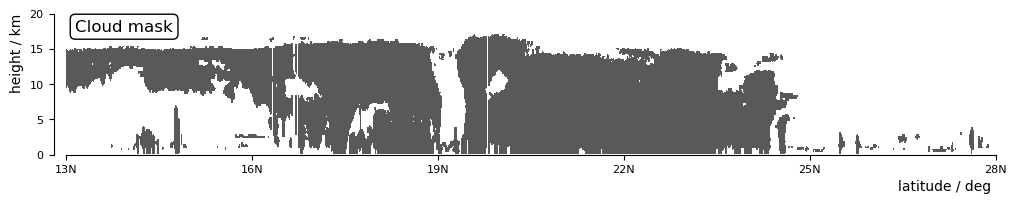

In [6]:
# plot cloud mask
cod = (1e-3*ds["COD"][1][:,1:]).values
cod[cod<0.01]=np.nan
cod[cod>=0.01]=1
plt.figure(figsize=(12,5.5/3))
make_hrplot(cod, extend="neither", cmap="gray_r", levels=np.linspace(0,1.5,11), text="Cloud mask",colorbar=False)

plt.savefig("cloudmask.pdf")
plt.savefig("cloudmask.png", dpi=1000)

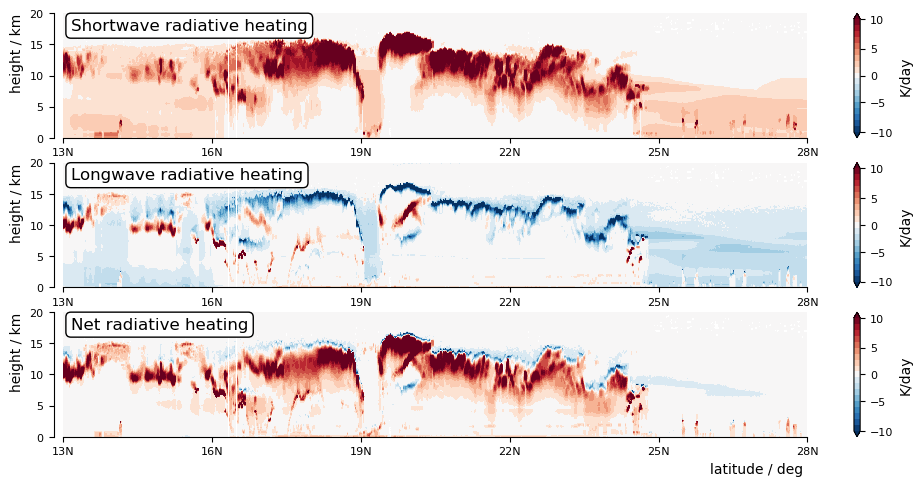

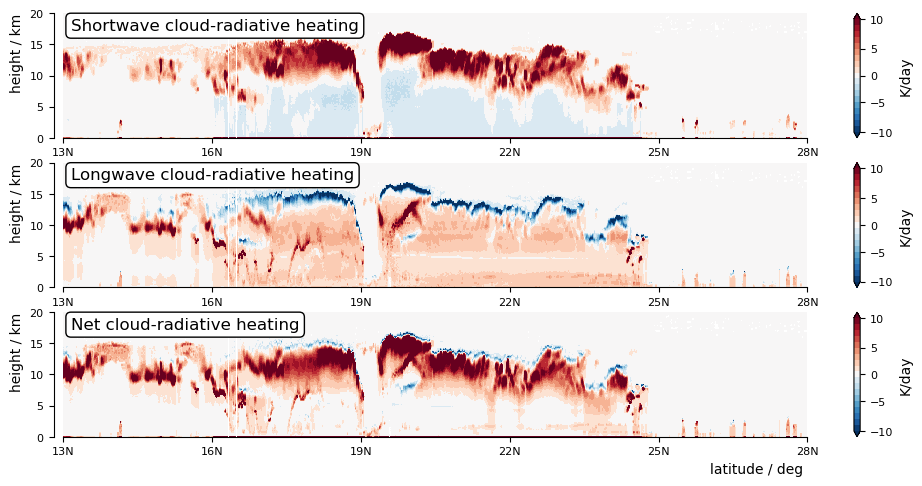

In [7]:
plt.figure(figsize=(12,5.5))
plt.subplot(3,1,1)
make_hrplot(sw_as, text="Shortwave radiative heating")
plt.subplot(3,1,2)
make_hrplot(lw_as, text="Longwave radiative heating")
plt.subplot(3,1,3)
make_hrplot(sw_as+lw_as, text="Net radiative heating")
plt.savefig("allsky_radiativeheating.pdf")
plt.savefig("allsky_radiativeheating.png", dpi=1000)

plt.figure(figsize=(12,5.5))
plt.subplot(3,1,1)
make_hrplot(sw_crh, text="Shortwave cloud-radiative heating")
plt.subplot(3,1,2)
make_hrplot(lw_crh, text="Longwave cloud-radiative heating")
plt.subplot(3,1,3)
make_hrplot(sw_crh+lw_crh, text="Net cloud-radiative heating")
plt.savefig("crh_radiativeheating.pdf")
plt.savefig("crh_radiativeheating.png", dpi=1000)

plt.figure(figsize=(12,5.5))
plt.subplot(3,1,1)
make_hrplot(sw_cs, text="Shortwave clear-sky radiative heating")
plt.subplot(3,1,2)
make_hrplot(lw_cs, text="Longwave clear-sky radiative heating")
plt.subplot(3,1,3)
make_hrplot(sw_cs+lw_cs, text="Net clear-sky radiative heating")
plt.savefig("clearsky_radiativeheating.pdf")
plt.savefig("clearsky_radiativeheating.png", dpi=1000)